In [1]:
from lighter_api import *
from process import *
from datetime import date, datetime, timezone
from IPython.display import display
from dotenv import load_dotenv

import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

print(health_check())

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai


True


In [2]:
start_date_str = "2022-01-01"
end_date_str = date.today().strftime("%Y-%m-%d")
print(start_date_str, end_date_str)

start_date = datetime.strptime(start_date_str, "%Y-%m-%d").replace(tzinfo=timezone.utc)
end_date = datetime.strptime(end_date_str, "%Y-%m-%d").replace(tzinfo=timezone.utc)
print(start_date, end_date)

start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())
print(start_timestamp, start_timestamp)

2022-01-01 2025-10-07
2022-01-01 00:00:00+00:00 2025-10-07 00:00:00+00:00
1640995200 1640995200


## Account

In [3]:
load_dotenv()

MY_L1_ADDRESS = os.getenv("MY_L1_ADDRESS")  # Set your wallet address in the .env file

account_index = get_account_index(MY_L1_ADDRESS)

print(json.dumps(account_index, indent=4))

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/accountsByL1Address


{
    "code": 200,
    "l1_address": "0x2A3edC8cA07Db5CbCf17e54F3dD964694a208076",
    "sub_accounts": [
        {
            "code": 0,
            "account_type": 0,
            "index": 64163,
            "l1_address": "0x2A3edC8cA07Db5CbCf17e54F3dD964694a208076",
            "cancel_all_time": 0,
            "total_order_count": 0,
            "total_isolated_order_count": 0,
            "pending_order_count": 0,
            "available_balance": "",
            "status": 0,
            "collateral": "712.854208"
        },
        {
            "code": 0,
            "account_type": 1,
            "index": 281474976684467,
            "l1_address": "0x2A3edC8cA07Db5CbCf17e54F3dD964694a208076",
            "cancel_all_time": 0,
            "total_order_count": 0,
            "total_isolated_order_count": 0,
            "pending_order_count": 0,
            "available_balance": "",
            "status": 0,
            "collateral": "0.000000"
        }
    ]
}


## Data Extraction

In [4]:
orderbook_details = get_orderbook_details()
order_book_details = orderbook_details.get("order_book_details")
orderbooks_by_market_id = {market["market_id"]: market for market in order_book_details}
# print(orderbooks_by_market_id)

market_ids = []
for market in order_book_details:
    market_ids.append(market["market_id"])
    if market['status'] != 'active':
        print(f"Market {market['market_id']} ({market['symbol']}) is not active")

market_ids.sort()
print('Active market ids: ', market_ids)
print('Number of active markets: ', len(market_ids))

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/orderBookDetails


Market 28 (MKR) is not active
Active market ids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
Number of active markets:  91


### Candlesticks

In [5]:
resolution = "1d"
id_candles_mapping = {}

for market_id in market_ids:
    # print(f"Processing market_id: {market_id}")
    try:
        candlesticks = fetch_candlesticks(
            market_id=str(market_id),
            resolution=resolution,
            start_timestamp=start_timestamp,
            end_timestamp=end_timestamp,
        )
        raw_candlesticks = candlesticks.get("candlesticks", [])
        candlesticks_df = pd.DataFrame(raw_candlesticks)
        candlesticks_df = convert_timestamp_column(candlesticks_df, "timestamp", unit="ms")
        id_candles_mapping[market_id] = candlesticks_df
        symbol = orderbooks_by_market_id[market_id]["symbol"]

        # print("\nFirst 5 rows:")
        # display(candlesticks_df.head())

        # print("\nLast 5 rows:")
        # display(candlesticks_df.tail())

        min_ts = candlesticks_df["timestamp"].min()
        max_ts = candlesticks_df["timestamp"].max()
        print(f"{market_id} ({symbol}) - Number of {resolution} candlesticks: {len(candlesticks_df)} range from {min_ts} to {max_ts}")
        # if min_ts > start_date:
        #     raise Exception(f"Warning: Fetched candlesticks timestamp above requested date start.")
        # print("=" * 40)
    except Exception as e:
        print(f"Error processing market_id {market_id}: {e}")

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks
INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


0 (ETH) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


1 (BTC) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


2 (SOL) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


3 (DOGE) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


4 (1000PEPE) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


5 (WIF) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


6 (WLD) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


7 (XRP) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


8 (LINK) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


9 (AVAX) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


10 (NEAR) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


11 (DOT) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


12 (TON) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


13 (TAO) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


14 (POL) - Number of 1d candlesticks: 262 range from 2025-01-17 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


15 (TRUMP) - Number of 1d candlesticks: 249 range from 2025-01-30 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


16 (SUI) - Number of 1d candlesticks: 248 range from 2025-01-31 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


17 (1000SHIB) - Number of 1d candlesticks: 248 range from 2025-01-31 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


18 (1000BONK) - Number of 1d candlesticks: 248 range from 2025-01-31 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


19 (1000FLOKI) - Number of 1d candlesticks: 248 range from 2025-01-31 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


20 (BERA) - Number of 1d candlesticks: 233 range from 2025-02-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


21 (FARTCOIN) - Number of 1d candlesticks: 233 range from 2025-02-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


22 (AI16Z) - Number of 1d candlesticks: 233 range from 2025-02-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


23 (POPCAT) - Number of 1d candlesticks: 233 range from 2025-02-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


24 (HYPE) - Number of 1d candlesticks: 224 range from 2025-02-24 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


25 (BNB) - Number of 1d candlesticks: 224 range from 2025-02-24 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


26 (JUP) - Number of 1d candlesticks: 224 range from 2025-02-24 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


27 (AAVE) - Number of 1d candlesticks: 215 range from 2025-03-05 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


28 (MKR) - Number of 1d candlesticks: 215 range from 2025-03-05 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


29 (ENA) - Number of 1d candlesticks: 215 range from 2025-03-05 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


30 (UNI) - Number of 1d candlesticks: 215 range from 2025-03-05 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


31 (APT) - Number of 1d candlesticks: 206 range from 2025-03-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


32 (SEI) - Number of 1d candlesticks: 206 range from 2025-03-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


33 (KAITO) - Number of 1d candlesticks: 192 range from 2025-03-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


34 (IP) - Number of 1d candlesticks: 192 range from 2025-03-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


35 (LTC) - Number of 1d candlesticks: 192 range from 2025-03-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


36 (CRV) - Number of 1d candlesticks: 166 range from 2025-04-23 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


37 (PENDLE) - Number of 1d candlesticks: 166 range from 2025-04-23 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


38 (ONDO) - Number of 1d candlesticks: 166 range from 2025-04-23 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


39 (ADA) - Number of 1d candlesticks: 144 range from 2025-05-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


40 (S) - Number of 1d candlesticks: 144 range from 2025-05-15 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


41 (VIRTUAL) - Number of 1d candlesticks: 115 range from 2025-06-13 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


42 (SPX) - Number of 1d candlesticks: 115 range from 2025-06-13 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


43 (TRX) - Number of 1d candlesticks: 97 range from 2025-07-01 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


44 (SYRUP) - Number of 1d candlesticks: 97 range from 2025-07-01 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


45 (PUMP) - Number of 1d candlesticks: 84 range from 2025-07-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


46 (LDO) - Number of 1d candlesticks: 75 range from 2025-07-23 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


47 (PENGU) - Number of 1d candlesticks: 75 range from 2025-07-23 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


48 (PAXG) - Number of 1d candlesticks: 70 range from 2025-07-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


49 (EIGEN) - Number of 1d candlesticks: 70 range from 2025-07-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


50 (ARB) - Number of 1d candlesticks: 70 range from 2025-07-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


51 (RESOLV) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


52 (GRASS) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


53 (ZORA) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


54 (LAUNCHCOIN) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


55 (OP) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


56 (ZK) - Number of 1d candlesticks: 69 range from 2025-07-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


57 (PROVE) - Number of 1d candlesticks: 62 range from 2025-08-05 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


58 (BCH) - Number of 1d candlesticks: 59 range from 2025-08-08 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


59 (HBAR) - Number of 1d candlesticks: 59 range from 2025-08-08 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


60 (ZRO) - Number of 1d candlesticks: 59 range from 2025-08-08 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


61 (GMX) - Number of 1d candlesticks: 53 range from 2025-08-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


62 (DYDX) - Number of 1d candlesticks: 53 range from 2025-08-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


63 (MNT) - Number of 1d candlesticks: 53 range from 2025-08-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


64 (ETHFI) - Number of 1d candlesticks: 53 range from 2025-08-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


65 (AERO) - Number of 1d candlesticks: 53 range from 2025-08-14 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


66 (USELESS) - Number of 1d candlesticks: 47 range from 2025-08-20 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


67 (TIA) - Number of 1d candlesticks: 47 range from 2025-08-20 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


68 (MORPHO) - Number of 1d candlesticks: 47 range from 2025-08-20 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


69 (VVV) - Number of 1d candlesticks: 47 range from 2025-08-20 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


70 (YZY) - Number of 1d candlesticks: 46 range from 2025-08-21 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


71 (XPL) - Number of 1d candlesticks: 41 range from 2025-08-26 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


72 (WLFI) - Number of 1d candlesticks: 41 range from 2025-08-26 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


73 (CRO) - Number of 1d candlesticks: 38 range from 2025-08-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


74 (NMR) - Number of 1d candlesticks: 38 range from 2025-08-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


75 (DOLO) - Number of 1d candlesticks: 38 range from 2025-08-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


76 (LINEA) - Number of 1d candlesticks: 35 range from 2025-09-01 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


77 (XMR) - Number of 1d candlesticks: 28 range from 2025-09-08 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


78 (PYTH) - Number of 1d candlesticks: 28 range from 2025-09-08 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


79 (SKY) - Number of 1d candlesticks: 18 range from 2025-09-18 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


80 (MYX) - Number of 1d candlesticks: 18 range from 2025-09-18 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


81 (1000TOSHI) - Number of 1d candlesticks: 18 range from 2025-09-18 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


82 (AVNT) - Number of 1d candlesticks: 18 range from 2025-09-18 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


83 (ASTER) - Number of 1d candlesticks: 18 range from 2025-09-18 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


84 (0G) - Number of 1d candlesticks: 12 range from 2025-09-24 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


85 (STBL) - Number of 1d candlesticks: 12 range from 2025-09-24 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


86 (APEX) - Number of 1d candlesticks: 8 range from 2025-09-28 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


87 (FF) - Number of 1d candlesticks: 7 range from 2025-09-29 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


88 (2Z) - Number of 1d candlesticks: 4 range from 2025-10-02 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/candlesticks


89 (EDEN) - Number of 1d candlesticks: 4 range from 2025-10-02 08:00:00+08:00 to 2025-10-05 08:00:00+08:00
90 (ZEC) - Number of 1d candlesticks: 3 range from 2025-10-03 08:00:00+08:00 to 2025-10-05 08:00:00+08:00


In [9]:
print("\nLast 5 rows:")
display(candlesticks_df.tail())


Last 5 rows:


,timestamp,open,high,low,close,volume0,volume1,last_trade_id
0,2025-10-03 08:00:00+08:00,156.891,157.183,127.280,127.605,38118.009,5.491293e+06,179921116
1,2025-10-04 08:00:00+08:00,127.605,176.477,124.483,157.067,78910.797,1.180258e+07,184727921
2,2025-10-05 08:00:00+08:00,157.067,172.657,144.000,165.545,80594.969,1.279190e+07,190817184


### Funding Rates

In [10]:
# LIMIT: Max previous 1 month
resolution = "1h"
id_funding_mapping = {}

for market_id in market_ids:
    # print(f"Processing market_id: {market_id}")
    try:
        funding_rates = fetch_funding_rates(
            market_id=str(market_id),
            resolution=resolution,
            start_timestamp=start_timestamp,
            end_timestamp=end_timestamp,
        )
        raw_fundings = funding_rates.get("fundings", [])
        fundings_df = pd.DataFrame(raw_fundings)
        fundings_df = convert_timestamp_column(fundings_df, "timestamp", unit="s")
        id_funding_mapping[market_id] = fundings_df
        symbol = orderbooks_by_market_id[market_id]["symbol"]

        # print("\nFirst 5 rows:")
        # display(fundings_df.head())

        # print("\nLast 5 rows:")
        # display(fundings_df.tail())

        min_ts = fundings_df["timestamp"].min()
        max_ts = fundings_df["timestamp"].max()
        print(f"{market_id} ({symbol}) - Number of {resolution} fundings: {len(fundings_df)} range from {min_ts} to {max_ts}")
        # if min_ts > start_date:
        #     raise Exception(f"Warning: Fetched funding rates timestamp above requested date start.")
        # print("=" * 40)
    except Exception as e:
        print(f"Error processing market_id {market_id}: {e}")

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings
INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


0 (ETH) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


1 (BTC) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


2 (SOL) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


3 (DOGE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


4 (1000PEPE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


5 (WIF) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


6 (WLD) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


7 (XRP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


8 (LINK) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


9 (AVAX) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


10 (NEAR) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


11 (DOT) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


12 (TON) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


13 (TAO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


14 (POL) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


15 (TRUMP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


16 (SUI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


17 (1000SHIB) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


18 (1000BONK) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


19 (1000FLOKI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


20 (BERA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


21 (FARTCOIN) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


22 (AI16Z) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


23 (POPCAT) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


24 (HYPE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


25 (BNB) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


26 (JUP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


27 (AAVE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


28 (MKR) - Number of 1h fundings: 1430 range from 2025-08-07 18:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


29 (ENA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


30 (UNI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


31 (APT) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


32 (SEI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


33 (KAITO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


34 (IP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


35 (LTC) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


36 (CRV) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


37 (PENDLE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


38 (ONDO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


39 (ADA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


40 (S) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


41 (VIRTUAL) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


42 (SPX) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


43 (TRX) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


44 (SYRUP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


45 (PUMP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


46 (LDO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


47 (PENGU) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


48 (PAXG) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


49 (EIGEN) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


50 (ARB) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


51 (RESOLV) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


52 (GRASS) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


53 (ZORA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


54 (LAUNCHCOIN) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


55 (OP) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


56 (ZK) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


57 (PROVE) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


58 (BCH) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


59 (HBAR) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


60 (ZRO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


61 (GMX) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


62 (DYDX) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


63 (MNT) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


64 (ETHFI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


65 (AERO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


66 (USELESS) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


67 (TIA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


68 (MORPHO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


69 (VVV) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


70 (YZY) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


71 (XPL) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


72 (WLFI) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


73 (CRO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


74 (NMR) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


75 (DOLO) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


76 (LINEA) - Number of 1h fundings: 749 range from 2025-09-05 03:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


77 (XMR) - Number of 1h fundings: 658 range from 2025-09-08 22:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


78 (PYTH) - Number of 1h fundings: 658 range from 2025-09-08 22:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


79 (SKY) - Number of 1h fundings: 421 range from 2025-09-18 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


80 (MYX) - Number of 1h fundings: 421 range from 2025-09-18 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


81 (1000TOSHI) - Number of 1h fundings: 421 range from 2025-09-18 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


82 (AVNT) - Number of 1h fundings: 421 range from 2025-09-18 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


83 (ASTER) - Number of 1h fundings: 416 range from 2025-09-19 00:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


84 (0G) - Number of 1h fundings: 272 range from 2025-09-25 00:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


85 (STBL) - Number of 1h fundings: 272 range from 2025-09-25 00:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


86 (APEX) - Number of 1h fundings: 181 range from 2025-09-28 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


87 (FF) - Number of 1h fundings: 151 range from 2025-09-30 01:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


88 (2Z) - Number of 1h fundings: 79 range from 2025-10-03 01:00:00+08:00 to 2025-10-06 07:00:00+08:00


INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/fundings


89 (EDEN) - Number of 1h fundings: 79 range from 2025-10-03 01:00:00+08:00 to 2025-10-06 07:00:00+08:00
90 (ZEC) - Number of 1h fundings: 61 range from 2025-10-03 19:00:00+08:00 to 2025-10-06 07:00:00+08:00


In [11]:
print("\nLast 5 rows:")
display(fundings_df.tail())


Last 5 rows:


,timestamp,value,rate,direction
56,2025-10-06 03:00:00+08:00,0.012,0.0070,long
57,2025-10-06 04:00:00+08:00,0.002,0.0012,long
58,2025-10-06 05:00:00+08:00,0.011,0.0070,long
59,2025-10-06 06:00:00+08:00,0.015,0.0092,long
60,2025-10-06 07:00:00+08:00,0.009,0.0056,long


## Volume Analysis

In [12]:
# Print total volume1 for each market in id_candles_mapping
all_token_total_volume1 = 0
for market_id, df in id_candles_mapping.items():
    if "volume1" in df.columns:
        total_volume1 = df["volume1"].sum()
        all_token_total_volume1 += total_volume1
        symbol = orderbooks_by_market_id[market_id]["symbol"]
        print(f"Market {market_id} ({symbol}) - Total volume1: ${total_volume1:,.2f} USD")
    else:
        print(f"Market {market_id} ({symbol}) - 'volume1' column not found.")
print(f"\nAll token total volume1: ${all_token_total_volume1:,.2f} USD")


Market 0 (ETH) - Total volume1: $126,730,372,852.26 USD
Market 1 (BTC) - Total volume1: $379,112,385,083.39 USD
Market 2 (SOL) - Total volume1: $19,941,126,289.23 USD
Market 3 (DOGE) - Total volume1: $786,618,308.63 USD
Market 4 (1000PEPE) - Total volume1: $678,604,903.08 USD
Market 5 (WIF) - Total volume1: $678,806,963.76 USD
Market 6 (WLD) - Total volume1: $484,899,211.66 USD
Market 7 (XRP) - Total volume1: $1,690,671,681.17 USD
Market 8 (LINK) - Total volume1: $798,739,678.70 USD
Market 9 (AVAX) - Total volume1: $492,154,559.05 USD
Market 10 (NEAR) - Total volume1: $524,693,423.52 USD
Market 11 (DOT) - Total volume1: $567,956,674.33 USD
Market 12 (TON) - Total volume1: $727,159,730.37 USD
Market 13 (TAO) - Total volume1: $307,842,800.65 USD
Market 14 (POL) - Total volume1: $740,348,112.10 USD
Market 15 (TRUMP) - Total volume1: $658,110,434.52 USD
Market 16 (SUI) - Total volume1: $1,024,894,839.48 USD
Market 17 (1000SHIB) - Total volume1: $395,034,387.50 USD
Market 18 (1000BONK) - To

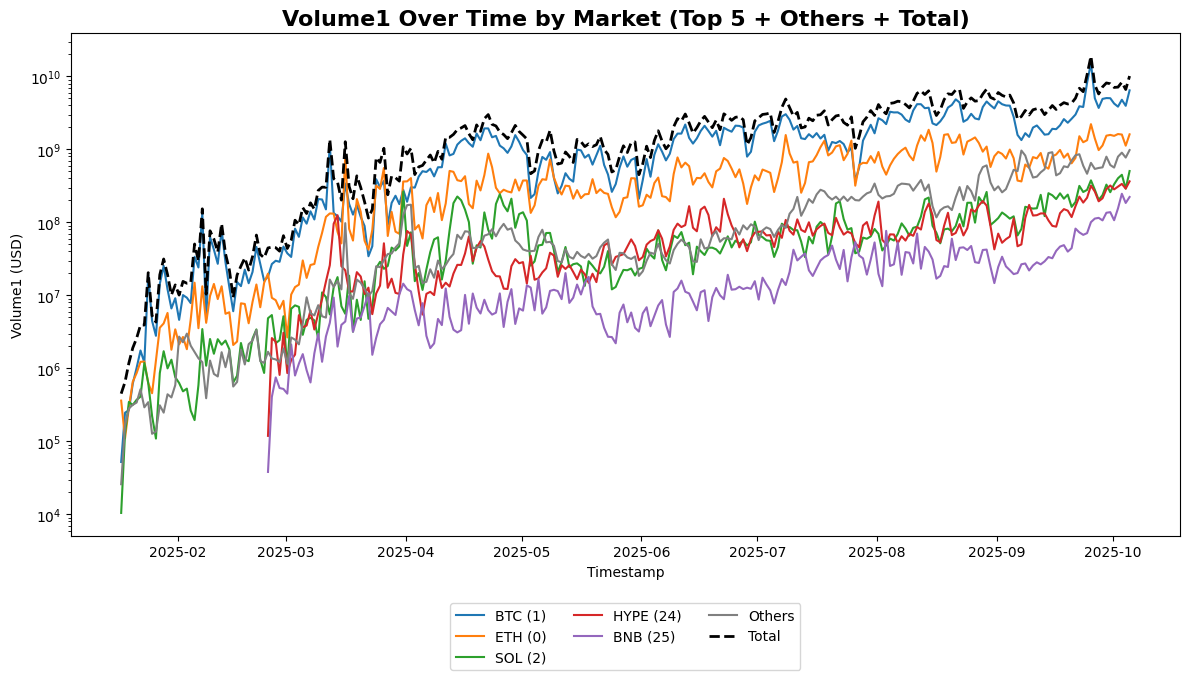

In [14]:
# Plot only the top 5 markets by total volume1, bucket all others as 'Others'

# Calculate total volume1 for each market
market_volumes = []
for market_id, df in id_candles_mapping.items():
    if "volume1" in df.columns:
        total_volume1 = df["volume1"].sum()
        symbol = orderbooks_by_market_id.get(market_id, {}).get("symbol", f"Market {market_id}")
        market_volumes.append((market_id, symbol, total_volume1))

# Sort by total volume1 descending and select top 5
market_volumes.sort(key=lambda x: x[2], reverse=True)
top5 = market_volumes[:5]
top5_ids = set(m[0] for m in top5)

# Prepare data for plotting
plt.figure(figsize=(12, 6))
lines = []
labels = []

# Plot top 5 markets
for market_id, symbol, _ in top5:
    df = id_candles_mapping[market_id]
    if "volume1" in df.columns:
        line, = plt.plot(df["timestamp"], df["volume1"], label=f"{symbol} ({market_id})")
        lines.append(line)
        labels.append(f"{symbol} ({market_id})")

# Bucket all other markets as 'Others'
others_dfs = []
for market_id, df in id_candles_mapping.items():
    if market_id not in top5_ids and "volume1" in df.columns:
        others_dfs.append(df[["timestamp", "volume1"]])

if others_dfs:
    # Concatenate and group by timestamp, summing volume1
    combined_others = pd.concat(others_dfs)
    others_grouped = combined_others.groupby("timestamp", as_index=False)["volume1"].sum()
    line, = plt.plot(others_grouped["timestamp"], others_grouped["volume1"], label="Others", color="gray")
    lines.append(line)
    labels.append("Others")

# Add a line for the total volume1 (sum across all markets) over time
# First, concatenate all DataFrames and group by timestamp
all_dfs = [df[["timestamp", "volume1"]] for df in id_candles_mapping.values() if "volume1" in df.columns]
if all_dfs:
    all_combined = pd.concat(all_dfs)
    total_grouped = all_combined.groupby("timestamp", as_index=False)["volume1"].sum()
    line, = plt.plot(total_grouped["timestamp"], total_grouped["volume1"], label="Total", color="black", linestyle="--", linewidth=2)
    lines.append(line)
    labels.append("Total")

plt.xlabel("Timestamp")
plt.ylabel("Volume1 (USD)")
plt.yscale("log")  # Set y-axis to log scale
plt.title("Volume1 Over Time by Market (Top 5 + Others + Total)", fontsize=16, fontweight='bold')
plt.tight_layout()
# Optimized legend: place at bottom, wrap if too many, use best location
plt.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True, fontsize="medium")

plt.show()

## Funding Rate Analysis

In [15]:
cutoff = end_date - timedelta(days=30)
print(f"End date: {end_date}, Cutoff: {cutoff}")

# Filter each market's funding data to only include the last 15 days from the latest timestamp
filtered_id_funding_mapping = {}

for market_id, df in id_funding_mapping.items():
    df = df.copy()
    # Compute signed funding: positive if direction is 'long', negative if 'short'
    df["funding"] = df["rate"].astype(float) * df["direction"].map(lambda x: 1 if x == "long" else -1)
    recent_df = df[df["timestamp"] >= cutoff]
    # recent_df["timestamp"] = recent_df["timestamp"].dt.strftime("%m-%d")
    filtered_id_funding_mapping[market_id] = recent_df


End date: 2025-10-06 00:00:00+00:00, Cutoff: 2025-09-06 00:00:00+00:00


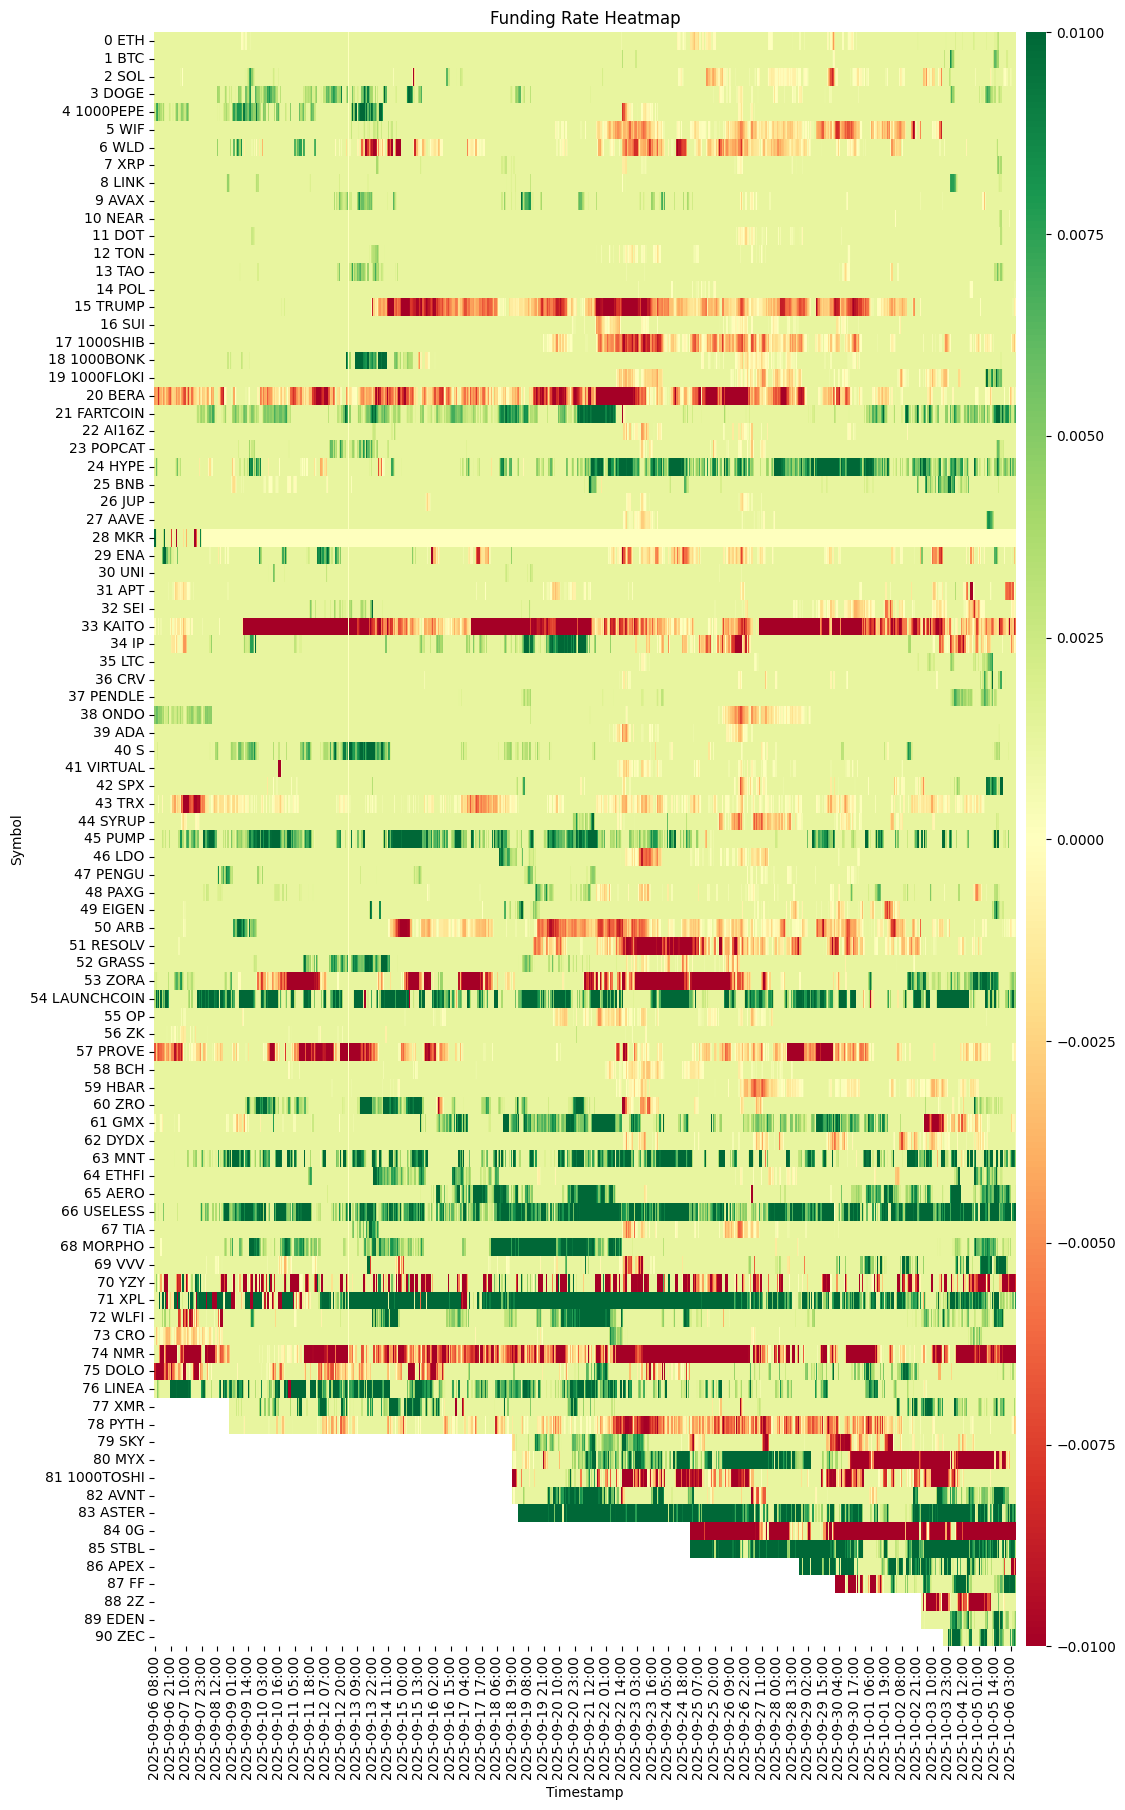

In [16]:
# Prepare funding heatmap data from filtered_id_funding_mapping
# Truncate timestamps to "YYYY-MM-DD HH:MM" format for columns
def truncate_timestamp(ts):
    # Handles both pd.Timestamp and string
    if hasattr(ts, 'strftime'):
        return ts.strftime("%Y-%m-%d %H:%M")
    else:
        # Try parsing string to pd.Timestamp
        try:
            return pd.to_datetime(ts).strftime("%Y-%m-%d %H:%M")
        except Exception:
            return str(ts)

# Collect all unique truncated timestamps
all_trunc_timestamps = sorted({
    truncate_timestamp(ts)
    for df in filtered_id_funding_mapping.values()
    for ts in df["timestamp"]
})

row_labels = [
    f"{market_id} {orderbooks_by_market_id.get(market_id, {}).get('symbol', f'Market {market_id}')}"
    for market_id in filtered_id_funding_mapping.keys()
]
heatmap_data = pd.DataFrame(index=row_labels, columns=all_trunc_timestamps)

for market_id, df in filtered_id_funding_mapping.items():
    row_label = f"{market_id} {orderbooks_by_market_id.get(market_id, {}).get('symbol', f'Market {market_id}')}"
    # Truncate timestamps for this df
    truncated_ts = df["timestamp"].apply(truncate_timestamp)
    # Assign funding values to the correct truncated timestamp columns
    for ts, funding in zip(truncated_ts, df["funding"].values):
        heatmap_data.loc[row_label, ts] = funding

heatmap_data = heatmap_data.astype(float)
# print(heatmap_data)

# Increase the height so symbols are clearly visible
num_symbols = len(heatmap_data.index)
height_per_symbol = 0.2  # You can adjust this value for more/less spacing
fig_height = max(6, num_symbols * height_per_symbol)
scale_limit = 0.01

plt.figure(figsize=(12, fig_height))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    center=0,
    vmin=-scale_limit,
    vmax=scale_limit,
    cbar_kws={
        # 'label': 'Funding Rate',
        # 'shrink': 0.6,   # reduce overall height/width
        'aspect': 80,     # larger = thinner colorbar
        'pad': 0.01
    },
)
plt.title("Funding Rate Heatmap")
plt.xlabel("Timestamp")
plt.ylabel("Symbol")
plt.tight_layout()
plt.show()


## Lighter Liquidity Provider (LLP) Stats

INFO:lighter_api:Making request to: https://mainnet.zklighter.elliot.ai/api/v1/account


Lighter Liquidity Provider (LLP) - Total asset value: $398,375,441.94 USD
Annual percentage yield: 61.37%
Total shares: 118286338279


,timestamp,share_price,share_value
258,2025-10-02 04:00:00+08:00,3.340311,3.951132e+08
259,2025-10-03 04:00:00+08:00,3.349817,3.962376e+08
260,2025-10-04 04:00:00+08:00,3.354706,3.968159e+08
261,2025-10-05 04:00:00+08:00,3.362027,3.976819e+08
262,2025-10-06 04:00:00+08:00,3.365689,3.981150e+08


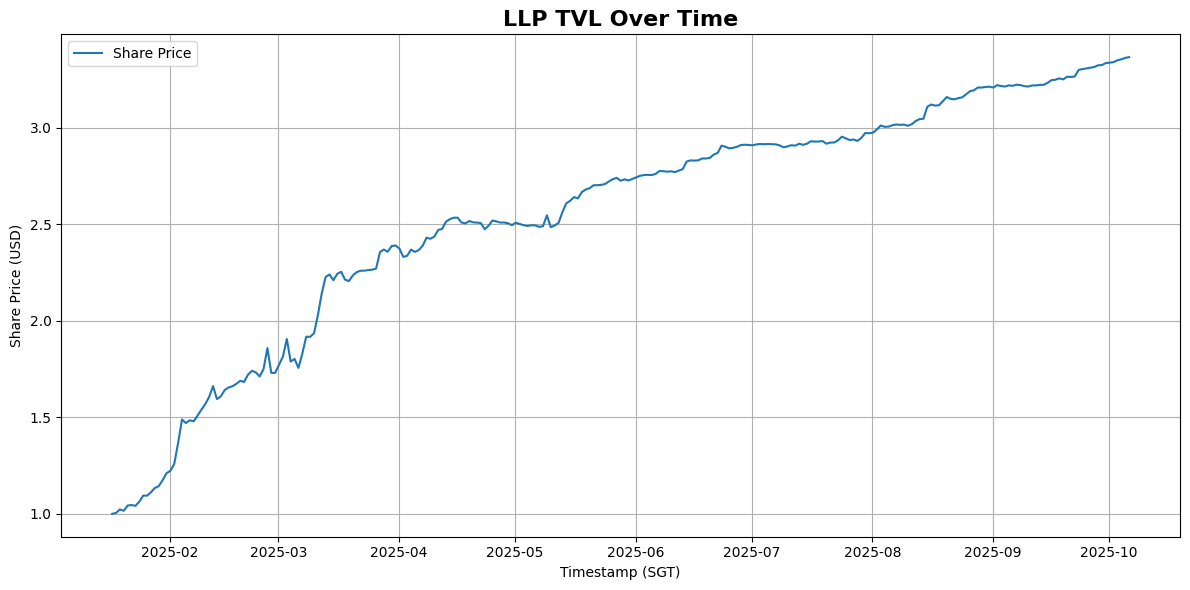

In [20]:
# get Lighter account by index

# get Lighter account by address
# get_account_info("l1_address", "0x0000000000000000000000000000000000000000")

# get Lighter account by index
LIGHTER_ACCOUNT_INDEX = "281474976710654"
lighter_account = get_account("index", LIGHTER_ACCOUNT_INDEX)

accounts_info = lighter_account.get("accounts")[0]
# print(json.dumps(accounts_info, indent=4))

name = accounts_info.get("name")
total_asset_value = accounts_info.get("total_asset_value")
print(f"{name} - Total asset value: ${float(total_asset_value):,.2f} USD")

pool_info = accounts_info.get("pool_info")
annual_percentage_yield = pool_info.get("annual_percentage_yield")
print(f"Annual percentage yield: {float(annual_percentage_yield):.2f}%")

daily_returns = pool_info.get("daily_returns")
df_daily_returns = pd.DataFrame(daily_returns)
df_daily_returns = convert_timestamp_column(df_daily_returns, "timestamp", unit="s")

# NAV Calculation
total_shares = pool_info.get("total_shares")
print(f"Total shares: {total_shares}")

share_price = pool_info.get("share_prices")
df_share_price = pd.DataFrame(share_price)
df_share_price = convert_timestamp_column(df_share_price, "timestamp", unit="s")

df_share_price['share_value'] = df_share_price['share_price'].astype(float) * total_shares
df_share_price['share_price'] = df_share_price['share_price'].astype(float) * 1000
display(df_share_price.tail())

# NAV Calculation (Manual)
# Calculate daily balance using the latest total_asset_value and daily returns
# Assume daily_return is the daily percentage return (e.g., 0.01 for 1%)
# We compute the balance for each day by applying cumulative returns backwards from the latest balance
# latest_balance = float(total_asset_value)
# # Reverse daily returns to go from latest to earliest
# returns = df_daily_returns["daily_return"].values[::-1]
# # Calculate cumulative product of (1 + daily_return)
# cumprod_returns = (1 + returns).cumprod()
# # Calculate balance for each day
# balances = latest_balance / cumprod_returns
# # Assign to DataFrame in correct order
# df_daily_returns["daily_balance"] = balances[::-1]

def plot_line(
    df,
    x_col,
    y_col,
    title="Line Plot",
    xlabel=None,
    ylabel=None,
    legend_label=None,
    figsize=(12, 6),
    grid=True,
):
    plt.figure(figsize=figsize)
    plt.plot(df[x_col], df[y_col], label=legend_label or y_col)
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.title(title, fontsize=16, fontweight='bold')
    if grid:
        plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Example usage:
# plot_line(
#     df_daily_returns,
#     x_col="timestamp",
#     y_col="daily_return",
#     title="Daily Return Over Time",
#     xlabel="Timestamp (SGT)",
#     ylabel="Daily Return",
#     legend_label="Daily Return"
# )

plot_line(
    df_share_price,
    x_col="timestamp",
    y_col="share_price",
    title="LLP TVL Over Time",
    xlabel="Timestamp (SGT)",
    ylabel="Share Price (USD)",
    legend_label="Share Price"
)


## Current Open Interest

Total Open Interest (USD): 2,082,822,675.50


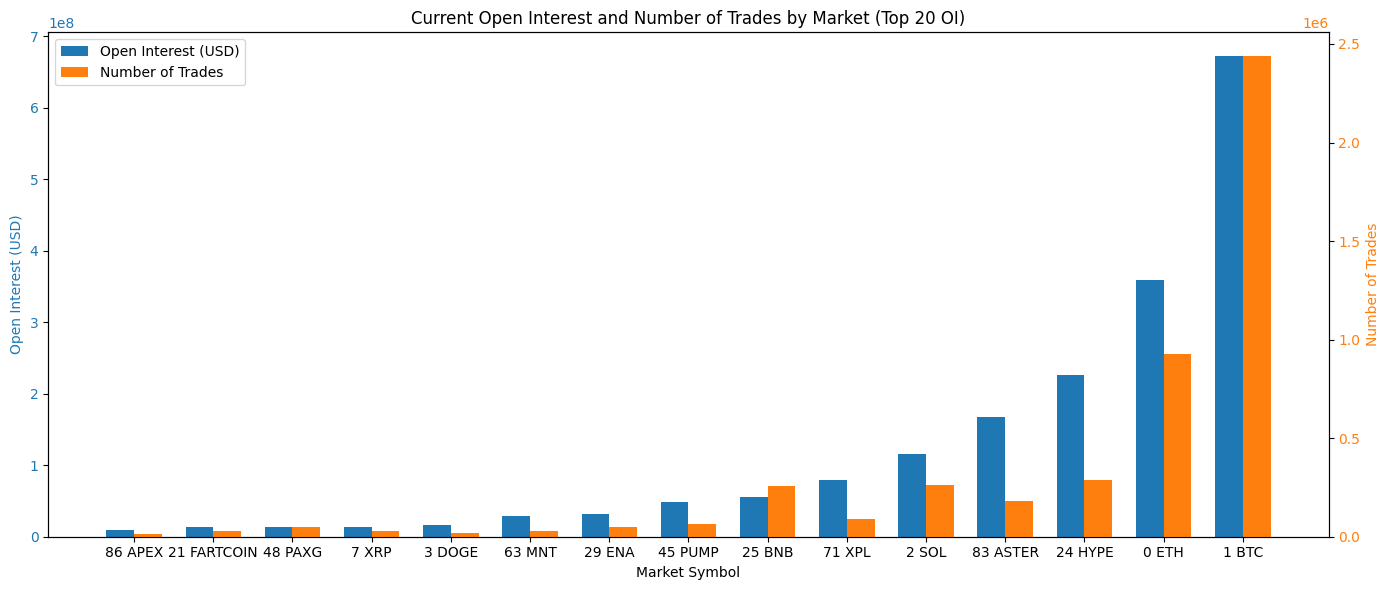

In [21]:
# Prepare oi_by_market_id, trades_by_market_id, and symbol mapping, then sort by open interest (oi)
oi_by_market_id = {}
trades_by_market_id = {}

for market_id, details in orderbooks_by_market_id.items():
    oi = details.get("open_interest", 0) * details.get("last_trade_price", 0) * 2
    trades = details.get("daily_trades_count", 0)
    oi_by_market_id[market_id] = oi
    trades_by_market_id[market_id] = trades

# Print total open interest
total_oi = sum(oi_by_market_id.values())
print(f"Total Open Interest (USD): {total_oi:,.2f}")

# Sort oi_by_market_id by value (oi), and filter to top 20
sorted_market_ids = [k for k, v in sorted(oi_by_market_id.items(), key=lambda item: item[1])[-15:]]
oi_by_market_id = {k: oi_by_market_id[k] for k in sorted_market_ids}
trades_by_market_id = {k: trades_by_market_id[k] for k in sorted_market_ids}

# Prepare data for plotting using the dictionaries
market_ids = list(oi_by_market_id.keys())
open_interests = list(oi_by_market_id.values())
trades_counts = [trades_by_market_id[mid] for mid in market_ids]
symbols = [str(market_id) + " " + orderbooks_by_market_id[market_id]["symbol"] for market_id in market_ids]
# print(market_ids)
# print(open_interests)
# print(trades_counts)
# print(symbols)

# Plot bar chart for open interest and trades count with secondary y-axis for trades count
x = np.arange(len(symbols))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar for open interest (left y-axis)
bar1 = ax1.bar(x - width/2, open_interests, width, label="Open Interest (USD)", color='tab:blue')
ax1.set_xlabel("Market Symbol")
ax1.set_ylabel("Open Interest (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis for trades count
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, trades_counts, width, label="Number of Trades", color='tab:orange')
ax2.set_ylabel("Number of Trades", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title("Current Open Interest and Number of Trades by Market (Top 20 OI)")
plt.xticks(x, symbols, rotation=90)  # Ensure x labels are rotated 90 degrees

fig.tight_layout()

# Add legends for both axes
bars = [bar1, bar2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left')

plt.show()
